# Testing photobleaching method

In [1]:
import numpy as np
import bokeh.io
import bokeh.plotting
import mscl.mcmc
import mscl.plotting
import mscl.process
import mscl.stats
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import theano.tensor as tt
colors = mscl.plotting.set_plotting_style()
%matplotlib inline

In [2]:
# Load the data
bleaching_data = pd.read_csv('../dilution_processing/20171129_sfGFP_10ngml_dilution/output/20171129_sfGFP_bleaching.csv')

In [3]:
# Group by strain.
auto_data = bleaching_data[bleaching_data['strain']=='autofluorescence']
delta_data = bleaching_data[bleaching_data['strain']=='delta']
auto_grouped = auto_data.groupby(['cell_id'])
delta_grouped = delta_data.groupby(['cell_id'])

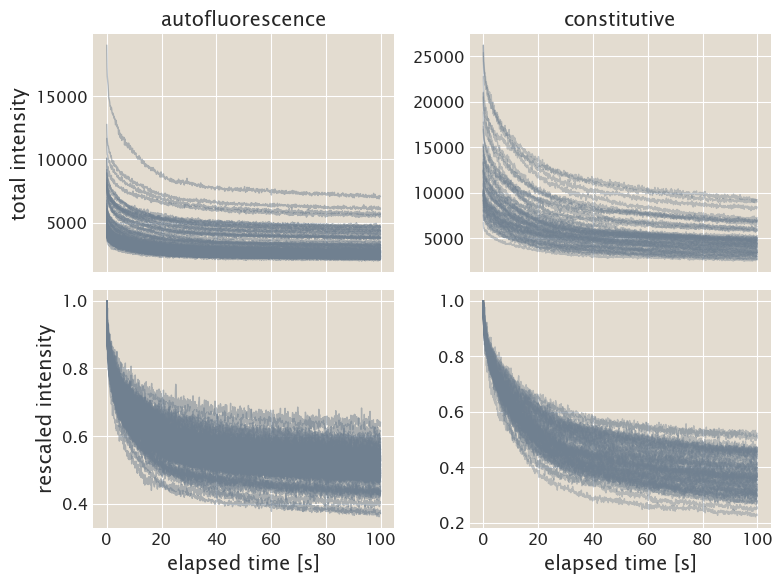

In [4]:
# Plot all of the rescaled values for each.
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(8,6))
ax[1, 0].set_xlabel('elapsed time [s]')
ax[1, 1].set_xlabel('elapsed time [s]')
ax[0, 0].set_ylabel('total intensity')
ax[1, 0].set_ylabel('rescaled intensity')
ax[0,0].set_title('autofluorescence')
ax[0, 1].set_title('constitutive')

for g, d in auto_grouped:
    _ = ax[0, 0].plot(d['elapsed_time_s'], d['total_intensity'], '-', lw=1, alpha=0.5, color='slategray')
    _ = ax[1, 0].plot(d['elapsed_time_s'], d['rescaled_intensity'], '-', lw=1, alpha=0.5, color='slategray')

for g, d in delta_grouped:
    _ = ax[0, 1].plot(d['elapsed_time_s'], d['total_intensity'], '-', lw=1, alpha=0.4, color='slategray')
    _ = ax[1, 1].plot(d['elapsed_time_s'], d['rescaled_intensity'], '-', lw=1, alpha=0.4, color='slategray')
    
plt.tight_layout()

In [12]:
# Subtract the means.
time = bleaching_data['elapsed_time_s'].unique()
auto_means = np.zeros(len(time))
delta_means = np.zeros(len(time))
grouped = bleaching_data.groupby(['strain', 'elapsed_time_s'])
auto_counter = 0
delta_counter = 0
for g, d in grouped:

    mean_val = d['total_intensity'].mean()
    if g[0] == 'autofluorescence':
        auto_means[auto_counter] = mean_val
        auto_counter += 1
    else:
        delta_means[delta_counter] = mean_val
        delta_counter += 1
sub_means = delta_means - auto_means

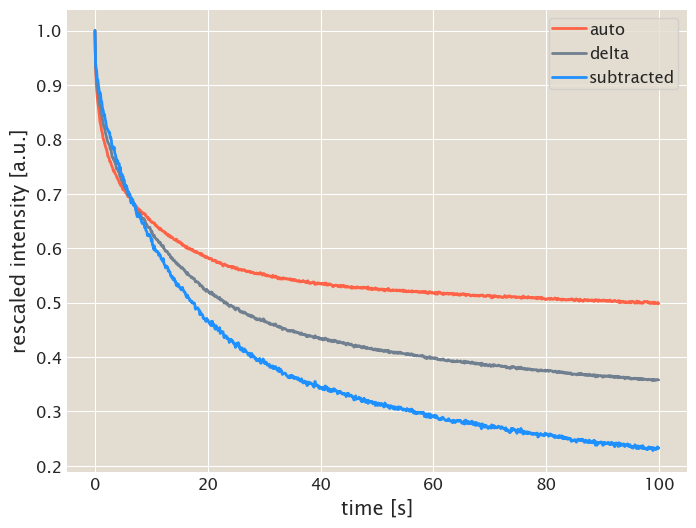

In [16]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('time [s]')
ax.set_ylabel('rescaled intensity [a.u.]')
time = bleaching_data['elapsed_time_s'].unique()
ax.plot(time, auto_means / auto_means[0], color='tomato', label='auto')
ax.plot(time, delta_means/ delta_means[0], color='slategray', label='delta')
ax.plot(time, sub_means / sub_means[0], color='dodgerblue', label='subtracted')
plt.legend()

In [28]:
sub_resc = sub_means / sub_means[0]
with pm.Model() as model:
    # Set the priors.
    bg = pm.Uniform('bg', lower=0, upper=1)
    beta_1 = pm.Uniform('beta_1', lower=0, upper=1)
    beta_2 = pm.Uniform('beta_2', lower=0, upper=1)
    tau_1 = pm.HalfNormal('tau_1', sd=100)
    tau_2 = pm.HalfNormal('tau_2', sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Compute the expected value.
    I_theo = bg + beta_1 * tt.exp(-time / tau_1) + beta_2 * tt.exp(-time / tau_2)
    
    # Sample the likelihood
    like = pm.Normal('like', mu=I_theo, sd=sigma, observed=sub_resc)
    trace = pm.sample(draws=5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10000/10000 [03:17<00:00, 50.67it/s]


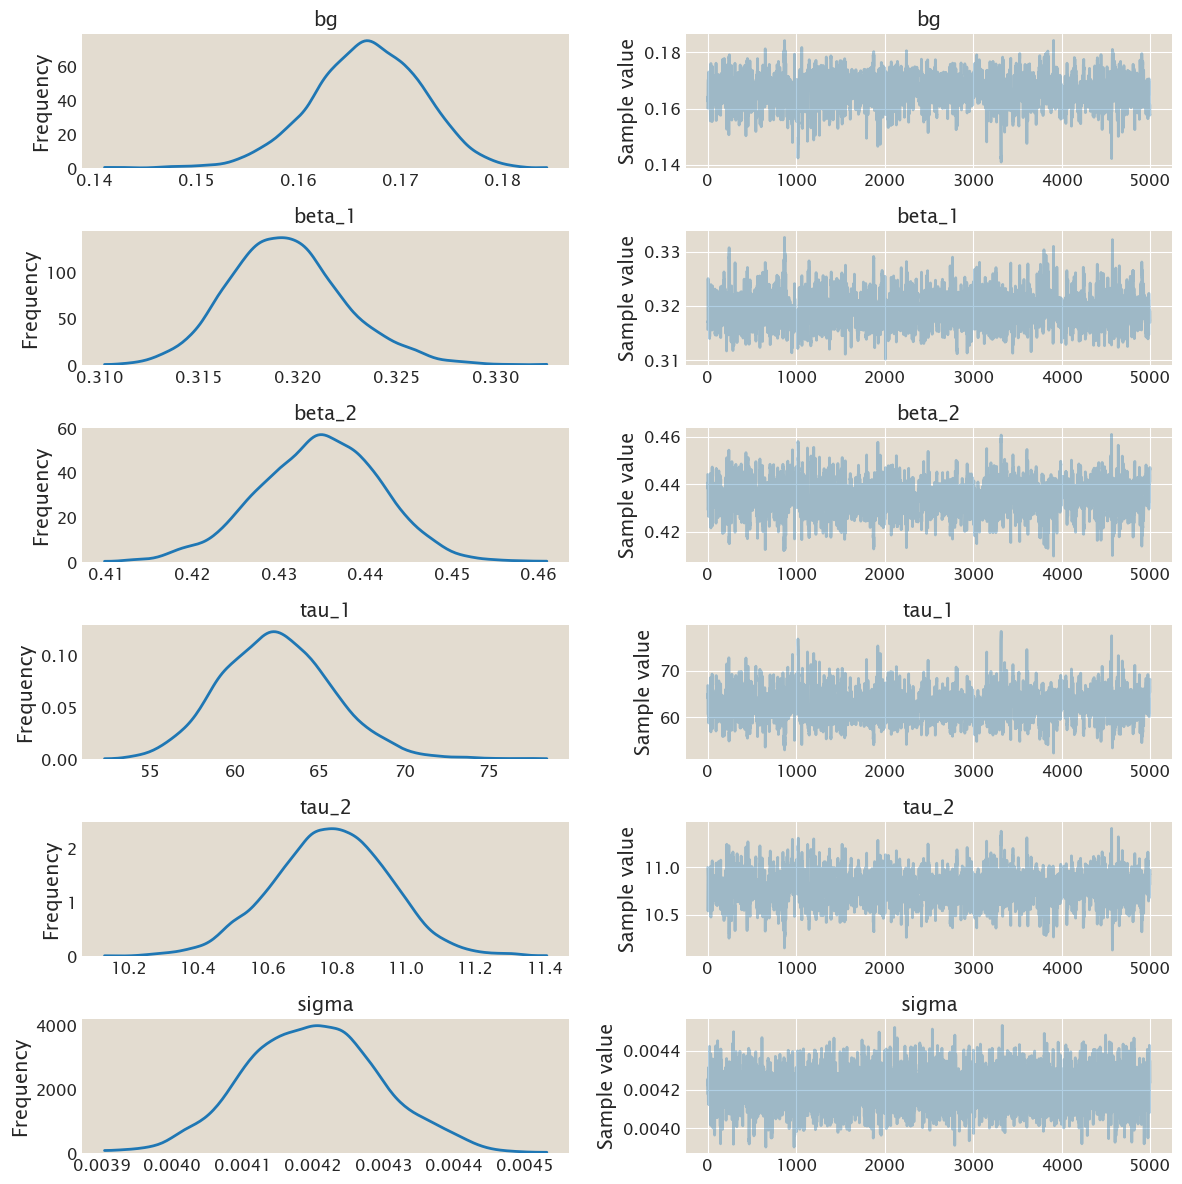

In [31]:
_ = pm.traceplot(trace)

In [32]:
df = mscl.mcmc.trace_to_dataframe(trace, model)
stats = mscl.mcmc.compute_statistics(df)
tau_1 = stats[stats['parameter']=='tau_1']['mode'].values[0]
tau_2 = stats[stats['parameter']=='tau_2']['mode'].values[0]
bg = stats[stats['parameter']=='bg']['mode'].values[0]
beta_1 = stats[stats['parameter']=='beta_1']['mode'].values[0]
beta_2 = stats[stats['parameter']=='beta_2']['mode'].values[0]

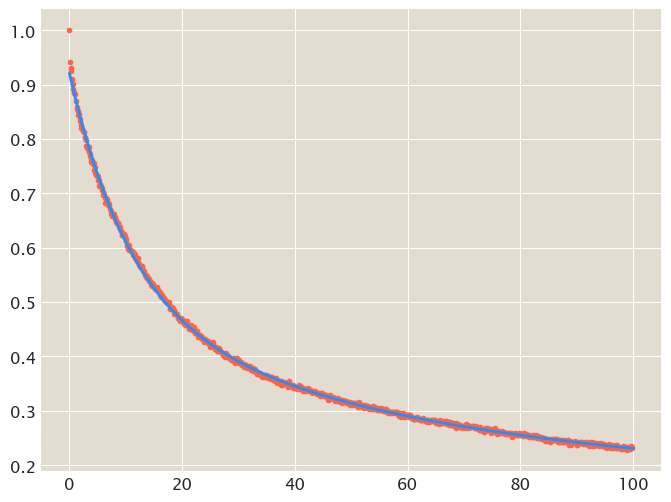

In [33]:
time_range = np.linspace(0, 100, 1000)
fit = bg + beta_1 * np.exp(-time_range / tau_1) + beta_2 * np.exp(-time_range / tau_2)
fig, ax = plt.subplots(1,1)
ax.plot(time, sub_resc, '.', color='tomato')
ax.plot(time_range, fit, color='dodgerblue')


## Heirarchical models.

In [7]:
n_cells = len(auto_data['cell_id'].unique())

with pm.Model() as auto_model:
    # Set the hyperpriors
    tau_mu = pm.HalfNormal('tau_mu', sd=100)
    tau_sig = pm.HalfNormal('tau_sig', sd=1)
    beta_mu = pm.Uniform('beta_mu', lower=0, upper=1)
    beta_sig = pm.HalfNormal('beta_sig', sd=1)
    bg_mu = pm.Uniform('bg_mu', lower=0, upper=1)
    bg_sig = pm.HalfNormal('bg_sig', sd=1)
    sig = pm.HalfNormal('sigma', sd=10)
    
    # Set the low-level priors 
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
    tau = pm.Normal('tau', mu=tau_mu, sd=tau_sig, shape=n_cells)
    beta = BoundedNormal('beta', mu=beta_mu, sd=beta_sig, shape=n_cells)
    bg = BoundedNormal('bg', mu=bg_mu, sd=bg_sig, shape=n_cells)
   
    # Set the observables.
    idx = auto_data['cell_id'].values.astype(int)
    time = auto_data['elapsed_time_s'].values
    obs = auto_data['rescaled_intensity'].values
    
    # Set the predicted value.
    I_theo = bg[idx] + beta[idx] * tt.exp(-time / tau[idx])
    
    # Define the likelihood and sample.
    likelihood = pm.Normal('like', mu=I_theo, sd=sig, observed=obs)
    advi = pm.ADVI()
    approx_fit = pm.fit(10000, method=advi)
    approx_trace = approx_fit.sample(5000)


Average Loss = 5,020.2: 100%|██████████| 10000/10000 [02:09<00:00, 77.16it/s]  
Finished [100%]: Average Loss = 4,708.2


In [5]:
grouped = auto_data.groupby('elapsed_time_s')
mean_auto = np.zeros(1000)
elapsed_time = np.zeros(1000)
i = 0
for g, d in grouped:
    mean_auto[i] = d['rescaled_intensity'].mean()
    elapsed_time[i] = g
    i += 1
    
with pm.Model() as mean_auto_model:
    # Define the priors.
    tau = pm.HalfNormal('tau', sd=100)
    bg = pm.Uniform('bg', lower=0, upper=1)
    beta = pm.Uniform('beta', lower=0, upper=1)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Define the theoretical result.
    I_theo = bg + beta * tt.exp(-elapsed_time / tau)
    
    # Sample
    like = pm.Normal('like', mu=I_theo, sd=sigma, observed=mean_auto)
    trace = pm.sample(draws=10000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 20000/20000 [00:44<00:00, 447.32it/s]


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


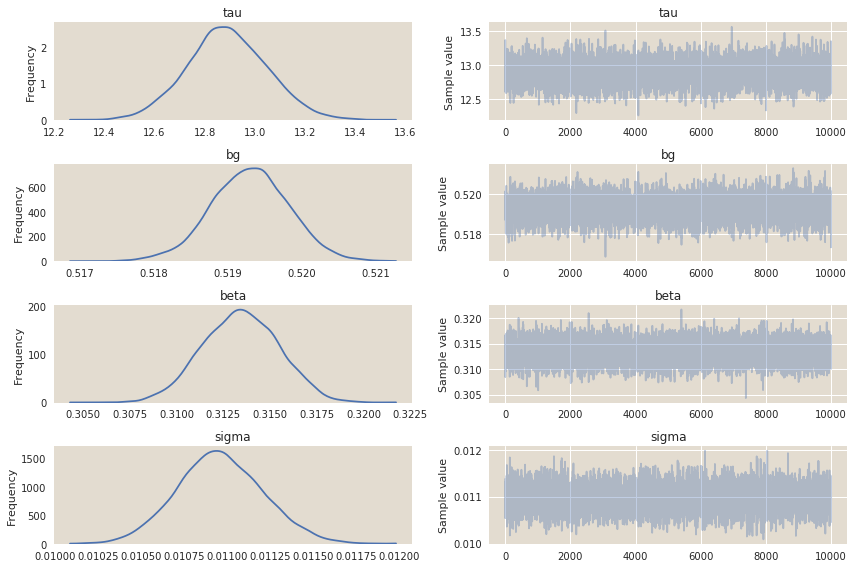

In [6]:
_ = pm.traceplot(trace)

In [23]:
df = mscl.mcmc.trace_to_dataframe(trace, mean_auto_model)
auto_stats = mscl.mcmc.compute_statistics(df)

In [24]:
auto_bg = auto_stats[auto_stats['parameter']=='bg']['mode'].values[0]
auto_beta = auto_stats[auto_stats['parameter']=='beta']['mode'].values[0]
auto_tau = auto_stats[auto_stats['parameter']=='tau']['mode'].values[0]

In [25]:
auto_tau_sd = np.mean(np.abs(auto_stats[auto_stats['parameter']=='tau'][['hpd_min', 'hpd_max']].values - auto_tau))
auto_beta_sd = np.mean(np.abs(auto_stats[auto_stats['parameter']=='beta'][['hpd_min', 'hpd_max']].values -auto_beta))

In [26]:
print(bg, beta, tau)

bg beta tau


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


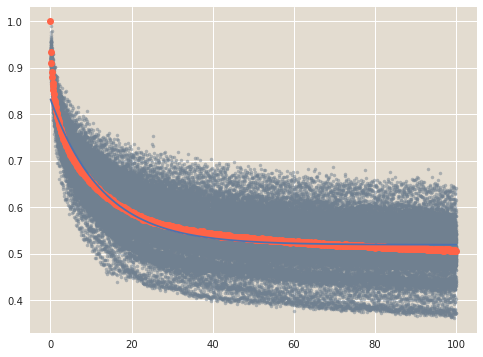

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
time_range = np.linspace(0, 100, 500)
theo = auto_bg + auto_beta * np.exp(-time_range / auto_tau)
_ = ax.plot(auto_data['elapsed_time_s'], auto_data['rescaled_intensity'], '.', color='slategray', alpha=0.5)
grouped = auto_data.groupby(['elapsed_time_s'])
for g, d in grouped:
    _ = ax.plot(g, d['rescaled_intensity'].mean(), 'o', color='tomato')

_ = ax.plot(time_range, theo, '-')


In [15]:
grouped = delta_data.groupby('elapsed_time_s')
mean_delta = np.zeros(1000)
elapsed_time = np.zeros(1000)
i = 0
for g, d in grouped:
    mean_delta[i] = d['rescaled_intensity'].mean()
    elapsed_time[i] = g
    i += 1
    

In [16]:
with pm.Model() as delta_mean_model:
    # Set the uninformative priors.
    tau = pm.HalfNormal('tau', sd=100)
    beta = pm.Uniform('beta', lower=0, upper=1)
    bg = pm.Uniform('bg', lower=0, upper=1)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Set the informative priors.
    tau_auto = pm.Normal('auto_tau', mu=auto_tau, sd=auto_tau_sd)
    beta_auto = pm.Normal('auto_beta', mu=auto_beta, sd=auto_beta_sd)
    
    # Compute the expected value.
    I_theo = bg + beta_auto * tt.exp(-elapsed_time / tau_auto) + beta * tt.exp(-elapsed_time / tau)
    
    # Sample.
    like = pm.Normal('likelihood', mu=I_theo, sd=sigma, observed=mean_delta)
    delta_trace = pm.sample(draws=5000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 15000/15000 [03:43<00:00, 67.15it/s]


In [19]:
# Extract the modes and plot the fit.
delta_df = mscl.mcmc.trace_to_dataframe(delta_trace, delta_mean_model)
delta_stats = mscl.mcmc.compute_statistics(delta_df)
tau_mode = delta_stats[delta_stats['parameter']=='tau']['mode'].values[0]
auto_tau_mode = delta_stats[delta_stats['parameter']=='auto_tau']['mode'].values[0]
beta_mode = delta_stats[delta_stats['parameter']=='beta']['mode'].values[0]
auto_beta_mode = delta_stats[delta_stats['parameter']=='auto_beta']['mode'].values[0]
bg_mode = delta_stats[delta_stats['parameter']=='bg']['mode'].values[0]

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


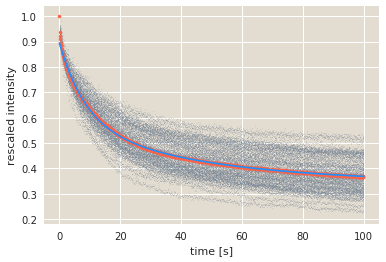

In [22]:
# Plot the fit
fig, ax  = plt.subplots(1,1)
ax.set_xlabel('time [s]')
ax.set_ylabel('rescaled intensity')
_ = ax.plot(delta_data['elapsed_time_s'], delta_data['rescaled_intensity'], ',', color='slategray',
           alpha=0.2)
_ = ax.plot(elapsed_time, mean_delta, '.', color='tomato')

# Compute the fit.
theo = bg_mode + beta_mode * np.exp(-time_range / tau_mode) + auto_beta_mode * np.exp(-time_range / auto_tau_mode)
_ = ax.plot(time_range, theo, color='dodgerblue')


In [17]:
# Extract the modes and HPD for informative priors
advi_df = mscl.mcmc.trace_to_dataframe(approx_trace, auto_model)
stats = mscl.mcmc.compute_statistics(advi_df)
auto_tau = np.mean(advi_df['tau_mu'])
auto_tau_sig = np.mean(advi_df['tau_sig'])
auto_beta = np.mean(advi_df['beta_mu'])
auto_beta_sig = np.mean(advi_df['beta_sig'])

NameError: name 'approx_trace' is not defined

In [ ]:
n_cells = len(delta_data['cell_id'].unique())
with pm.Model() as delta_model:
    # Set the hyperpriors.
    gfp_tau = pm.HalfNormal('gfp_tau', sd=100)
    gfp_sig = pm.HalfNormal('gfp_sig', sd=1)
    bg_mu = pm.Uniform('bg_mu',lower=0, upper=1)
    bg_sig = pm.HalfNormal('bg_sig', sd=1)
    beta_mu = pm.Uniform('beta_mu', lower=0, upper=1)
    beta_sig = pm.HalfNormal('beta_sig', sd=1)
    sigma = pm.HalfNormal('sig', sd=10)
    
    # Set the low-level priors
    tau = pm.Normal('tau', mu=gfp_tau, sd=gfp_sig, shape=n_cells)
    bg = pm.Normal('bg', mu=bg_mu, sd=bg_sig, shape=n_cells)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sig, shape=n_cells)
    
    # Set the priors for the autofluorescence contribution.
#     auto_tau_mcmc = pm.Normal('auto_tau', mu=auto_tau, sd=auto_tau_sig, shape=n_cells)
#     auto_beta_mcmc = pm.Normal('auto_beta', mu=auto_beta, sd=auto_beta_sig, shape=n_cells)
    
    # Define the observables and compute.
    idx = delta_data['cell_id'].values
    time = delta_data['elapsed_time_s'].values
    obs = delta_data['rescaled_intensity'].values
    I_theo = bg[idx] + beta[idx] * tt.exp(-time / tau[idx]) 

    
    # Define the likelihood and sample.
    like = pm.Normal('like', mu=I_theo, sd=sigma, observed=obs)
    delta_trace = pm.sample(draws=100, tune=200)

In [ ]:
_ = pm.traceplot(delta_trace)

In [ ]:
trace_df = pm.trace_to_dataframe(approx_trace)
_ = corner.corner(trace_df[['tau_mu', 'beta_mu', 'bg_mu']])